In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.dates as mdates

Load 3YP specific libraries

In [4]:
os.chdir("/Users/scotwheeler/Documents/repos/leo_3yp_2020/")  # set working directory to main folder, one folder above where this notebook is stored


# import modules from OxEMF package
from OxEMF import Assets as AS
from OxEMF import EnergySystem as ES      
import OxEMF.Market as MK

os.chdir("OxEMF/")

Setup parameters

In [5]:
dt = 30/60 # 30 minute time intervals
T = int((24*365)/dt) #Number of intervals

## Setup Assets

In [6]:
dispatchable_groups = []
non_dispatchable_groups = []
all_assets_groups = []

In [7]:
#PV source
pv_assets = []
for cap in range(0, 70, 5):
    pv_assets.append(AS.pvAsset(cap))
non_dispatchable_groups.append(pv_assets)

In [8]:
#Load
load_assets = []
for nHouses in [10]:
    load_assets.append(AS.loadAsset(nHouses))
non_dispatchable_groups.append(load_assets)

In [9]:
#Battery
batt_assets = []
n_batts = list(range(0,5))
batt_char = []
for n in n_batts:
    batt_char.append([n*20, n*5, 0.8])  # [cap, pow, eff]
for batt in batt_char:
    battery_site = AS.PracticalBatteryAsset(batt[0], batt[1], dt, T, eff= batt[2], install_cost=200)
    batt_assets.append(battery_site)
dispatchable_groups.append(batt_assets)

### Basic grid search

In [10]:
# setup ndarray to hold results
all_assets_groups = non_dispatchable_groups + dispatchable_groups
systems = np.ndarray((len(pv_assets),len(load_assets),len(batt_assets)), dtype=object)
net_loads = np.ndarray((len(pv_assets),len(load_assets),len(batt_assets)), dtype=object)
purchaseds = np.ndarray((len(pv_assets),len(load_assets),len(batt_assets)), dtype=object)
solds = np.ndarray((len(pv_assets),len(load_assets),len(batt_assets)), dtype=object)
total_costs = np.ndarray((len(pv_assets),len(load_assets),len(batt_assets)))


In [11]:
for i, pv in enumerate(pv_assets):
    for j, load in enumerate(load_assets):
        for k, batt in enumerate(batt_assets):
            non_dispatchable = [pv, load]
            dispatchable = [batt]
            all_assets = non_dispatchable + dispatchable
            energy_system = ES.EnergySystem(non_dispatchable, dispatchable, dt, T)
            net_load = energy_system.basic_energy_balance()
            systems[i,j,k] = energy_system
            net_loads[i,j,k] = net_load
            market = MK.marketObject(energy_system, pd.datetime(2017,1,1), pd.datetime(2017,12,31,23,59,59))
            total_cost = market.getTotalCost()
            total_costs[i,j,k] = total_cost / 100 # p to £
            purchased, sold = market.gridBreakdown()
            purchaseds[i,j,k] = purchased / 100 # p to £
            solds[i,j,k] = sold / 100 # p to £

/Users/scotwheeler/anaconda3/envs/LEO3YP2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


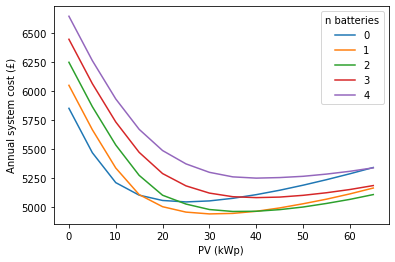

In [12]:
fig, ax = plt.subplots()
ax.plot(range(0,70,5), total_costs[:,0,:])
ax.set_xlabel("PV (kWp)")
ax.set_ylabel("Annual system cost (£)")
ax.legend(labels=range(0,5), loc=0, title="n batteries")
#ax.set_ybound(0)
plt.show()

## Analysis

In [13]:
oal = [5,0,2] # rough optimal locations

pv_daily = ES.E_to_dailyE(pv_assets[oal[0]].output, dt)
load_daily = ES.E_to_dailyE(load_assets[oal[1]].output, dt)
net_daily = ES.E_to_dailyE(net_loads[oal[0],oal[1],oal[2]], dt)
purchased_daily = ES.E_to_dailyE(purchaseds[oal[0],oal[1],oal[2]], dt)
sold_daily = ES.E_to_dailyE(solds[oal[0],oal[1],oal[2]], dt)
daily_cost = purchased_daily + sold_daily
daily_pv_price = np.ones(len(daily_cost)) * (
    ((pv_assets[oal[0]].install_cost * pv_assets[oal[0]].capacity)/pv_assets[oal[0]].lifetime)/365) / 100

In [14]:
oal = [12,0,0] # some non-optimal asset locations

pv_daily_no = ES.E_to_dailyE(pv_assets[oal[0]].output, dt)
load_daily_no = ES.E_to_dailyE(load_assets[oal[1]].output, dt)
net_daily_no = ES.E_to_dailyE(net_loads[oal[0],oal[1],oal[2]], dt)
purchased_daily_no = ES.E_to_dailyE(purchaseds[oal[0],oal[1],oal[2]], dt)
sold_daily_no = ES.E_to_dailyE(solds[oal[0],oal[1],oal[2]], dt)
daily_cost_no = purchased_daily_no + sold_daily_no
daily_pv_price_no = np.ones(len(daily_cost_no)) * (
    ((pv_assets[oal[0]].install_cost * pv_assets[oal[0]].capacity)/pv_assets[oal[0]].lifetime)/365) / 100

In [15]:
mit = market.mip
mit_daily = mit.reshape(int(len(mit)/(24/dt)), int(24/dt)).mean(axis=1)

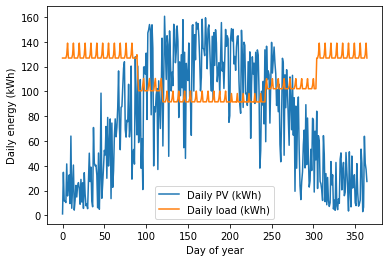

In [16]:
fig, ax = plt.subplots()
p1 = ax.plot(range(365), pv_daily, label="Daily PV (kWh)")
p2 = ax.plot(range(365), load_daily, label="Daily load (kWh)")
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily energy (kWh)")
ax.legend()
plt.show()

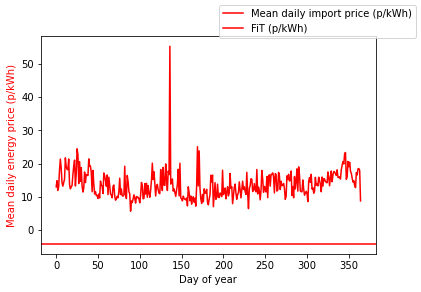

In [17]:
fig, ax = plt.subplots()
p2 = ax.plot(range(365), mit_daily, 'r', label="Mean daily import price (p/kWh)")
ax.set_xlabel("Day of year")
ax.set_ylabel("Mean daily energy price (p/kWh)", color='r')
ax.axhline(-4.2, color='r', label="FiT (p/kWh)")
fig.legend()
plt.show()

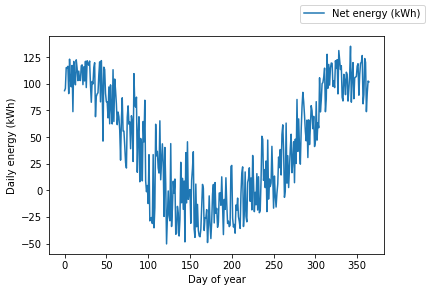

In [18]:
fig, ax = plt.subplots()
p1 = ax.plot(range(365), net_daily, label="Net energy (kWh)")
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily energy (kWh)")

fig.legend()
plt.show()

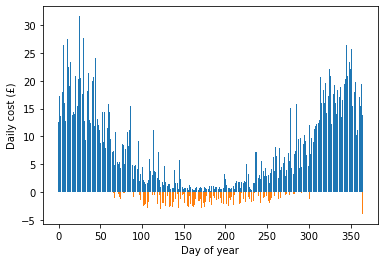

In [19]:
fig, ax = plt.subplots()
p1 = ax.bar(range(365), purchased_daily, label="Daily import cost")
p2 = ax.bar(range(365), sold_daily, label="Daily export profit")
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily cost (£)")
plt.show()

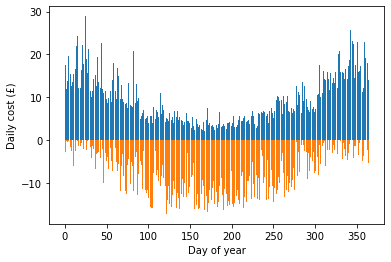

In [20]:
fig, ax = plt.subplots()
p1 = ax.bar(range(365), purchased_daily_no, label="Daily import cost")
p2 = ax.bar(range(365), sold_daily_no, label="Daily export profit")
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily cost (£)")
plt.show()

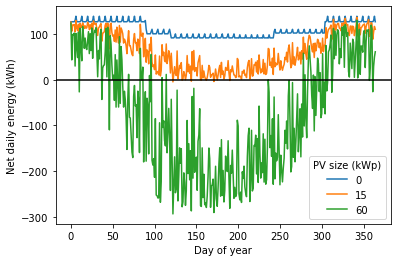

In [21]:
pv_net_loads = []
for load in net_loads[[0,3,12],0,0]:
    pv_net_loads.append(ES.E_to_dailyE(load, dt))
pv_net_loads = np.array(pv_net_loads)
fig, ax = plt.subplots()
p1 = ax.plot(range(365), pv_net_loads.T)
ax.axhline(0, color='k')
ax.set_xlabel("Day of year")
ax.set_ylabel("Net daily energy (kWh)")
ax.legend(labels=["0", "15", "60"], title="PV size (kWp)")
plt.show()

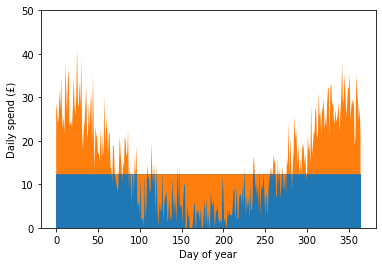

In [22]:
fig, ax = plt.subplots()
p1 = ax.stackplot(range(365), [daily_pv_price_no, daily_cost_no])
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily spend (£)")
ax.set_ybound(0,50)
plt.show()

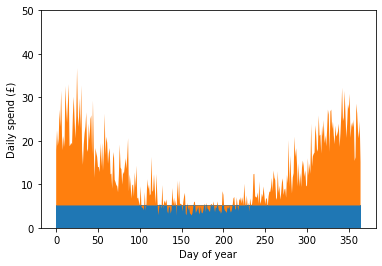

In [23]:
fig, ax = plt.subplots()
p1 = ax.stackplot(range(365), [daily_pv_price, daily_cost])
ax.set_xlabel("Day of year")
ax.set_ylabel("Daily spend (£)")
ax.set_ybound(0,50)
plt.show()

Now